<a href="https://colab.research.google.com/github/nbkwon/ml-assignment/blob/master/ml_assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# we now need pyplot for plotting data
import matplotlib.pyplot as pyplot
def show_plot(download_file = False):
    pyplot.legend()
    pyplot.show()
    if download_file == False:
       return
    
    import google.colab
    file_name = "test.png"
    pyplot.savefig(file_name)
    google.colab.files.download(file_name)

def make_plot(plot_data_list, use_this = None):
    # it's too samll. make bigger.
    if use_this is None:
        pyplot.figure(figsize=(8, 8))
    else:
        # use_this.set_figheight(8)
        # use_this.set_figwidth(8)
        pass

    for data_dic, plot_type, color, label in plot_data_list:
        if plot_type is "plot":
            if use_this is None:
                pyplot.plot(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)
            else:
                use_this.plot(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)    
        if plot_type is "scatter":
            if use_this is None:
                pyplot.scatter(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)
            else:
                use_this.scatter(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)

In [4]:
from zipfile import ZipFile
file_name = "movie_review.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

print("Start Load Data")
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()


for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

max_features = 3000

vectorizer = CountVectorizer(max_features=max_features, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Start Load Data


In [6]:
from functools import reduce
import cupy as cp

def check_convergence(loss, loss_after):
    # float 형의 자료형 동일한지 판단을 위해 numpy의 isclose를 사용.
    # atol = 0.0000000000000000001
    return abs(np.sum(loss - loss_after)) < 0.00000000000000001
    # return np.isclose(loss, loss_after)
    # return numpy.isclose(theta_list, new_theta_list)


def sigmoid_one(value):
    return 1 / (1 + np.exp(-value))
    
def sigmoid(value):
    r = 1 / (1 + cp.exp(-value))
    return r

def vstack(f):
    bias = cp.ones((1, f.shape[1]))
    return cp.vstack((f, bias))

def npmul(a, b):
    # 2차원에 한해서 dot과 matmul은 동일함.
    return cp.matmul(a,b)

def get_by_mat(mat_list, factor_list):
    result_list = []

    factors = factor_list
    result_list.append(factors)

    # mat 196 x 785
    # mat 784(+1) * 6000
    # -> 196 * 6000 
    for mat in mat_list:
        factors_with_bias = vstack(factors)
     
        factors = npmul(mat, factors_with_bias)
        factors = sigmoid(factors)
        result_list.append(factors)

    
    return result_list

def log(n):
    float_min = 0.00000000000000001
    n[n<float_min] = float_min
    n = cp.log(n)
    
    return n

def get_ret_list(mat_list, f_list):
    ret = get_by_mat(mat_list, f_list)
    return ret

def get_theta_count(mat_list):
    count = 0
    for m in mat_list:
        count += m.shape[0] * m.shape[1]
    return count

def calc_energy_value(mat_list, f_list, d_list, ret_list, lamb):
    #d_list = [0 0 0 0 1 0 0 0 0 0]
    #ret_list = [[0....0]
    # for r_in_d, ret in zip(d_list, ret_list[-1]):
    ret = ret_list[-1]
    # print(d_list[0], ret[0])
    # print((1 - d_list) * log(1 - ret))
    calculated = -d_list * log(ret) - (1 - d_list) * log(1 - ret)
    calculated /= len(d_list)

    loss = cp.sum(calculated)
    theta_loss = 0
    for m in mat_list:
        theta_loss += cp.sum(m ** 2)

    theta_loss *= (lamb / (2 * get_theta_count(mat_list)))
    # return calculated
    # print(calculated)

    return loss + theta_loss

def calc_next_gradient(lr, mat_list, f_list, d_list, ret_list, lamb):
    h_list = ret_list[-1]
    calculated_error = (h_list - d_list) 
    #     calculated_error = (-d_list/h_list) + (1-d_list) * (1 / (1 - h_list)
    # calculated_error *= h_list * (1 - h_list )  

    error_list = calculated_error  / len(d_list)

    new_mat_list = []
    theta_count = get_theta_count(mat_list)

    for i in range(len(mat_list)-1, -1, -1):
        now_mat = mat_list[i]
        new_mat = now_mat.copy()

        factor_with_bias = vstack(ret_list[i])
        # print(factor_with_bias.shape)
        # print(error_list.shape)
        calced = lr * (npmul(error_list,factor_with_bias.transpose()) + (lamb / theta_count) * now_mat)
        # print("new_mat calced", new_mat.shape, calced.shape)
        new_mat -= calced

        new_mat_list.append(new_mat)

        # error_list 갱신. 레이어의 에러를 미리 계산하는거라서 끝난상황이면 갱신할 필요가 없다.
        if(i - 1 < 0):
            continue
        
        v = ret_list[i]
        v = v * (1 - v)
        a = cp.dot(now_mat.transpose(), error_list)
        # print("check dLdz dzdz(i-1) (i)", v.shape, factor_with_bias.shape)
        
        # 49 * 60 -> 50 * 60
        new_error_list = v * a[:-1, ]
        # print("new error_list", new_error_list.shape)
        error_list = new_error_list
    
    # print("new_mat_list len", len(new_mat_list))
    new_mat_list.reverse()

    return new_mat_list

def calc_accuracy(ret_list, answer_list):
    calc = cp.copy(ret_list[-1][0])
    ans = cp.copy(answer_list)
    calc[calc<0.5] = 0
    calc[calc>=0.5] = 1
    ans[ans<0.5] = 0
    ans[ans>=0.5] = 1
    corrected = cp.sum(calc == ans)
    
    count = len(answer_list)

    # print("accuracy count", count)
    # print(calculated)
    # print(answer)       
    # print(corrected)

    return  corrected / count

# print(list_label)

def make_thetas(x, y):
    a = cp.random.normal(0, 1, x * y).reshape(x,y)
    # a = cp.ones(x * y).reshape(x,y) * 0.0001
    return a

driver = lambda x: to_label_list(x)

train_list_label_arranged = cp.array(y_train)
test_list_label_arranged = cp.array(y_test)

train_image = X_train.transpose()
test_image = X_test.transpose()

def make_mat_list(node_list):
    mat_list = []

    pre = max_features
    for node in node_list:
        nex = node 
        mat_list.append(make_thetas(nex, pre + 1))
        pre = nex
    mat_list.append(make_thetas(1, pre + 1))

    return mat_list

from timeit import default_timer as timer
s = timer()
lr = 0.6993922
lr = 2.6993922
lamb = 200

# test value
# lr = 0.6
# lamb = 0.01

max_acc = 0
rand_max_acc = 0
while True:
    import random
    
    node_list = []
    node_list.append(random.randint(400, 1000))
    # node_list.append(random.randint(100, 600))

    mat_seed = random.randint(1,10000)

    np.random.seed(mat_seed)
    mats = make_mat_list(node_list)

    lamb = 200 + random.random() * 200

    step_count = 0

    stpcnt_train_costs = {}
    stpcnt_test_costs = {}

    stpcnt_train_accuracy = {}
    stpcnt_test_accuracy = {}

    # node_list = [488]
    # np.random.seed(8815)
    # mats = make_mat_list(node_list)
    # lamb = 295.3625379592222

    max_acc = 0


    while True:
        train_ret_list = get_ret_list(mats, train_image)
        train_cost = calc_energy_value(mats, train_image, train_list_label_arranged, train_ret_list, lamb)

        test_ret_list = get_ret_list(mats, test_image)
        test_cost = calc_energy_value(mats, test_image, test_list_label_arranged, test_ret_list, lamb)

        stpcnt_train_costs[step_count] = float(train_cost)
        stpcnt_test_costs[step_count] = float(test_cost)

        stpcnt_train_accuracy[step_count] = calc_accuracy(train_ret_list, train_list_label_arranged)
        stpcnt_test_accuracy[step_count] = calc_accuracy(test_ret_list, test_list_label_arranged)

        
        new_lr = lr
        
        # if step_count % 50 == 49:
        #     print("loop", step_count, "accu", stpcnt_train_accuracy[step_count], stpcnt_test_accuracy[step_count], "loss", stpcnt_train_costs[step_count], stpcnt_test_costs[step_count])
        #     print(f"max acc refresh. {max_acc} step_count{step_count}")
        #     pass
        
        acc = stpcnt_test_accuracy[step_count]
        if max_acc < acc:
            max_acc = acc

        if acc > 0.85:
            lr = lr * 0.95
        
        if acc > 0.86:
            lr = lr * 0.1

        if step_count > 20000 and max_acc < 0.85:
            break 

        new_mats = calc_next_gradient(new_lr, mats, train_image, train_list_label_arranged, train_ret_list, lamb)
        mats = new_mats

        if (step_count > 2 and check_convergence(stpcnt_train_costs[step_count-1], stpcnt_train_costs[step_count])):
            break

        step_count = step_count + 1
    
    if acc > 0.85:
        break

    cur_max_acc = max(list(stpcnt_test_accuracy.values()))
    if rand_max_acc < cur_max_acc:
        print(f"max acc refresh. {cur_max_acc} node_list{node_list} lamb{lamb} seed{mat_seed} step_count{step_count} lr {lr}")
        rand_max_acc = cur_max_acc
    else:
        print(f"acc tried. {cur_max_acc} node_list{node_list} lamb{lamb}")
    



e = timer()
print("소요시간", e - s)
print(f"acc. {acc} node_list{node_list} lamb{lamb} seed{mat_seed} step_count{step_count}")
# print(list(stpcnt_train_costs.values()))
# print(list(stpcnt_test_costs.values()))

# 50 ~ ~ 60


소요시간 630.091703561
acc. 0.8502495840266223 node_list[665] lamb240.10567347298573 seed1646 step_count7333


1. Plot the loss curve

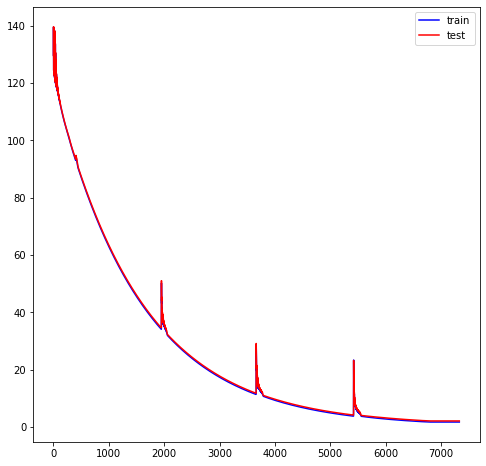

In [10]:
make_plot([(stpcnt_train_costs, "plot", "blue", "train"), (stpcnt_test_costs, "plot", "red", "test") ])
show_plot()

2. Plot the accuracy curve

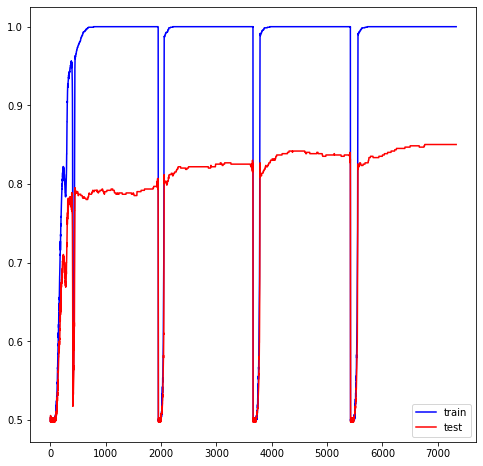

In [11]:
make_plot([(stpcnt_train_accuracy, "plot", "blue", "train"), (stpcnt_test_accuracy, "plot", "red", "test") ])

show_plot()

3. Plot the quantitative results

In [14]:
def ret_to_pred(ret_list):
    rets = cp.asnumpy(ret_list[-1][0])
    rets[rets<0.5] = 0
    rets[rets>=0.5] = 1
    return rets

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_train = ret_to_pred(train_ret_list)
y_pred_test = ret_to_pred(test_ret_list)
print("---------------------Training results", "(Confusion Matrix, Classification_report, Accuracy score(in percentage)")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train,y_pred_train))
print(accuracy_score(y_train, y_pred_train) * 100 , "%")
print("---------------------Testing results")
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test, y_pred_test) * 100 , "%")


---------------------Training results (Confusion Matrix, Classification_report, Accuracy score(in percentage)
[[699   0]
 [  0 702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

100.0 %
---------------------Testing results
[[252  50]
 [ 40 259]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       302
           1       0.84      0.87      0.85       299

    accuracy                           0.85       601
   macro avg       0.85      0.85      0.85       601
weighted avg       0.85      0.85      0.85       601

85.02495840266224 %
